# Project for NLP classes 2024

## Clothing information from books in Jane Austen novels

Authors: Zofia Hendrysiak and Kamil Tomaszek

## Import

In [39]:
import requests # making HTTP requests
import re # regular expressions

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # sentiment analysis
from nltk.tokenize import sent_tokenize # tokenising sentences
from nltk import pos_tag # part-of-speech tagging
from nltk import WordNetLemmatizer # lemmatisation
from nltk.corpus import wordnet # WordNet

import nltk
nltk.download('punkt') # the Punkt corpus
nltk.download('wordnet') # WordNet
nltk.download('averaged_perceptron_tagger') # POS tagging


#!pip3 install wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /Users/kvmilos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kvmilos/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kvmilos/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Defining Austen books

In [40]:
# Creating a list of dictionaries, where each dictionary is a separate book to be analysed
# Each dictionary contains the title of the book and the URL
austen = [
    {"title": "Pride and Prejudice", "url": "https://gutenberg.org/cache/epub/1342/pg1342.txt"},
    {"title": "Emma", "url": "https://www.gutenberg.org/cache/epub/158/pg158.txt"},
    {"title": "Sense and Sensibility", "url": "https://www.gutenberg.org/cache/epub/161/pg161.txt"},
    {"title": "Persuasion", "url": "https://www.gutenberg.org/cache/epub/105/pg105.txt"},
    {"title": "Northanger Abbey", "url": "https://www.gutenberg.org/cache/epub/121/pg121.txt"},
    {"title": "Mansfield Park", "url": "https://www.gutenberg.org/cache/epub/141/pg141.txt"}
]

## Functions for data processing and clothing information extraction 

In [41]:
# Function to update the dictionary with the text of the book
def get_text(books):
    for book in books:
        if "text" in book:
            continue
        url = book["url"]
        response = requests.get(url)
        if response.status_code == 200:
            book["text"] = response.text
        else:
            print(f"Error: {response.status_code}")
get_text(austen)


In [42]:
# Creating a RegEx pattern for clothes that may be mentioned in the book
clothes_pattern = r"\b(anklet|apron|armband|ascot|bandeau|bathing\W?suit|batiste|banyan|belt|binding|blouse|bodice|boot|boots|bowtie|bracelet|braces|breeches|brocade|brooch|button|buttonhole|cambric|camisole|cape|caftan|calico|cameo|cap|chemise|chemisette|choker|cloak|coat|collar|corset|cravat|crinoline|cuff|cufflink|cutaway|dart|diamante|diadem|dimity|dressing\W?gown|dress|drawstring|dungarees|earring|elastic|embroidery|epaulette|evening\W?ndress|eyelet|fastener|flap|flounce|frill|fringe|frock|gaiters|gather|gingham|glove|gloves|godet|gore|greatcoat|grommet|gusset|gown|handkerchief|hat|hem|hood|hook\W?and\W?eye|hoop|insert|interfacing|jabot|jacket|jewel|jewelry|kerchief|kirtle|lace|lining|linsey\W?woolsey|livery|locket|mantle|mittens|mitten|morning\W?dress|muff|mull|muslin|neck\W?cloth|necklace|neckerchief|night\W?gown|organdy|overalls|overcoat|overskirt|pannier|pantaloons|panel|peplum|pelisse|pendant|petticoat|pin|placket|plastron|pleat|plush|pocket|pocket\W?square|quilt|revers|rhinestones|ribbon|riding\W?shabit|robe|roquelaure|ruff|ruffle|sash|satin|scarf|seam|sequins|shawl|shirring|shoe|shoes|silk|slippers|smocking|snap|spencer|stays|stocking|strap|stud|suit|surplice|suspenders|surtout|sweater|tabard|tablier|taffeta|tailcoat|tarlatan|tassel|tie|tippet|top\W?hat|trim|trousers|tunic|turban|underskirt|undersleeve|velcro|velvet|vent|vest|waistband|waistcoat|walking\W?dress|watch|wingtip|wimple|yoke|zipper)\b"

In [43]:
# Function to analyze the sentiment of a sentence
def analyse_sentiment_vader(sentence):
    analyser = SentimentIntensityAnalyzer()
    score = analyser.polarity_scores(sentence)

    if score['compound'] >= 0.05:
        return "positive"
    elif score['compound'] <= -0.05:
        return "negative"
    else:
        return "neutral"

In [44]:
# Function to get the WordNet POS tag
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [45]:
# Function to lemmatise a word
def lemmatize(word):
    lemma = word
    pos_tagged = pos_tag([word])
    wordnet_pos = get_wordnet_pos(pos_tagged[0][1]) or wordnet.NOUN
    lemma = nltk.WordNetLemmatizer().lemmatize(word, pos=wordnet_pos)
    return lemma

## Data analysis

In [46]:
# Function to tokenise the text into sentences and analyse the sentiment of each sentence. The function also extracts the clothes mentioned in each sentence
def analyse_text(text):
    clothes_data = {}
    sentences = sent_tokenize(text)
    for sentence in sentences:
        items = re.findall(clothes_pattern, sentence, re.IGNORECASE)
        for item in items:
            item = item.lower()
            # If the last letter is 's', lemmatize the item. That is to have it in singular form
            if item[-1] == 's':
                item = lemmatize(item)
            if item in clothes_data:
                clothes_data[item]['occurrences'] += 1
                clothes_data[item]['sentiment'].append(analyse_sentiment_vader(sentence))
            else:
                clothes_data[item] = {
                    'occurrences': 1, 
                    'sentiment': [analyse_sentiment_vader(sentence)]
                    }
    return clothes_data

## Defining first visualisation function

In [47]:
# Function to visualize the data of the books using wordcloud
def visualise_books_data(author):
    get_text(author)
    num_books = len(author)
    rows = 2
    cols = num_books // 2 + num_books % 2  # Adjusting columns based on number of books
    
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    
    for i, book in enumerate(author):
        title = book['title']
        text = book['text']
        sentiment_data = analyse_text(text)
        
        # Generate word cloud
        word_freq = {word: details['occurrences'] for word, details in sentiment_data.items()}
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_freq)
        
        # Plot on the corresponding subplot
        ax = axs[i // cols, i % cols]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(title)
        ax.axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

## Defining second visualisation function

In [48]:
def sum_sentiment_occurrences(author_clothes):
    total = {}
    for book in author_clothes:
        for item in book["sent_occ"]:
            if item in total:
                total[item]['occurrences'] += book["sent_occ"][item]['occurrences']
                total[item]['positive'] += book["sent_occ"][item]['sentiment'].count('positive')
                total[item]['negative'] += book["sent_occ"][item]['sentiment'].count('negative')
                total[item]['neutral'] += book["sent_occ"][item]['sentiment'].count('neutral')
            else:
                total[item] = {
                    'occurrences': book["sent_occ"][item]['occurrences'],
                    'positive': book["sent_occ"][item]['sentiment'].count('positive'),
                    'negative': book["sent_occ"][item]['sentiment'].count('negative'),
                    'neutral': book["sent_occ"][item]['sentiment'].count('neutral'),
                }
    return total

In [49]:
def sentiment_and_occurences_visualisation(author):

    get_text(author)
    author_clothes = [{"sent_occ": analyse_text(author[i]["text"]), "title": author[i]["title"]} for i in range(len(author))]
    
    summed_data = sum_sentiment_occurrences(author_clothes)
    
    # Word cloud
    word_freq = {word: details['occurrences'] for word, details in summed_data.items()}
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(word_freq)
    
    # Most common words
    most_common = {k: v for k, v in sorted(summed_data.items(), key=lambda item: item[1]['occurrences'], reverse=True)[:10]}
    
    # Prepare data for the bar chart
    words = list(most_common.keys())
    positive_counts = [most_common[word]['positive'] for word in words]
    negative_counts = [most_common[word]['negative'] for word in words]
    neutral_counts = [most_common[word]['neutral'] for word in words]
    
    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle("Word Cloud, Most Common Words, and Sentiment Distribution")
    
    # Word Cloud
    ax[0].imshow(wordcloud, interpolation='bilinear')
    ax[0].axis('off')  # Hide the axes
    ax[0].set_title("Word Cloud")
    
    # Bar Chart
    bar_width = 0.25
    bar_positions = range(len(words))
    
    ax[1].bar(bar_positions, positive_counts, bar_width, label='Positive', color='g')
    ax[1].bar([p + bar_width for p in bar_positions], negative_counts, bar_width, label='Negative', color='r')
    ax[1].bar([p + bar_width * 2 for p in bar_positions], neutral_counts, bar_width, label='Neutral', color='b')
    
    ax[1].set_title("Most Common Words by Sentiment")
    ax[1].set_ylabel("Occurrences")
    ax[1].set_xlabel("Words")
    ax[1].set_xticks([p + bar_width for p in bar_positions])
    ax[1].set_xticklabels(words, rotation=45)
    ax[1].legend()
    
    # Pie Chart for overall sentiment distribution
    total_positive = sum(positive_counts)
    total_negative = sum(negative_counts)
    total_neutral = sum(neutral_counts)
    
    ax[2].pie([total_positive, total_negative, total_neutral], labels=['Positive', 'Negative', 'Neutral'], autopct='%1.1f%%', colors=['g', 'r', 'b'])
    ax[2].set_title("Overall Sentiment Distribution")
    
    plt.show()

## Austen - visualisation

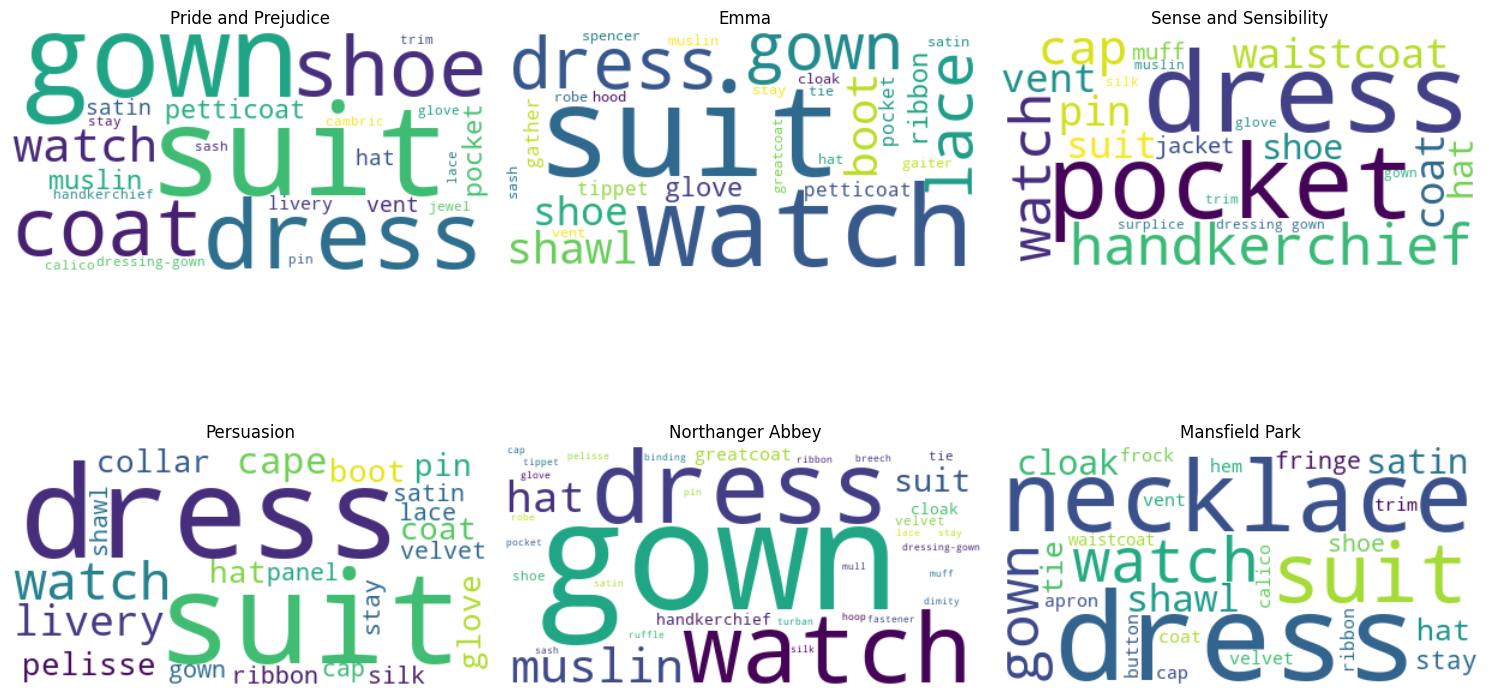

In [50]:
visualise_books_data(austen)

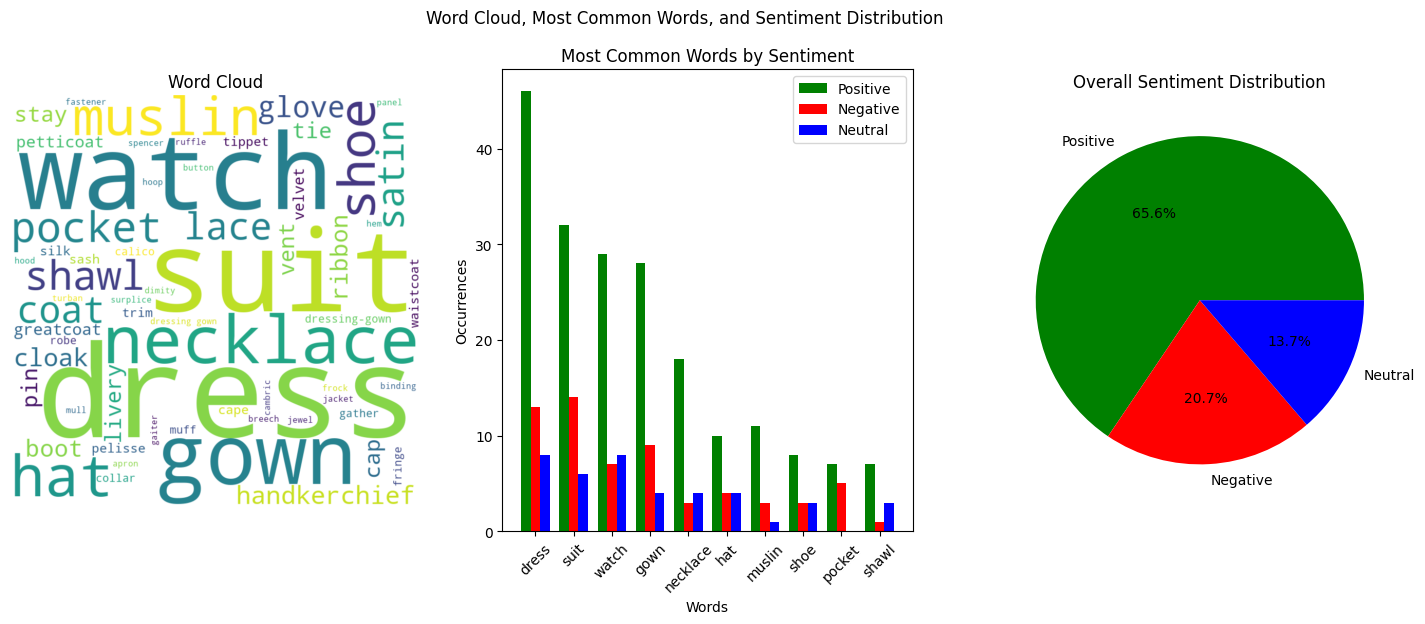

In [51]:
sentiment_and_occurences_visualisation(austen)

## Conrad - visualisation

In [52]:
conrad = [
    {"title": "Heart of Darkness", "url": "https://www.gutenberg.org/cache/epub/219/pg219.txt"},
    {"title": "Lord Jim", "url": "https://www.gutenberg.org/cache/epub/5658/pg5658.txt"},
    {"title": "Nostromo", "url": "https://www.gutenberg.org/cache/epub/2021/pg2021.txt"},
    {"title": "Victory: An Island Tale", "url": "https://www.gutenberg.org/cache/epub/6378/pg6378.txt"},
    {"title": "The Secret Agent: A Simple Tale", "url": "https://www.gutenberg.org/cache/epub/974/pg974.txt"},
    {"title": "The Secret Sharer", "url": "https://www.gutenberg.org/cache/epub/220/pg220.txt"}
]

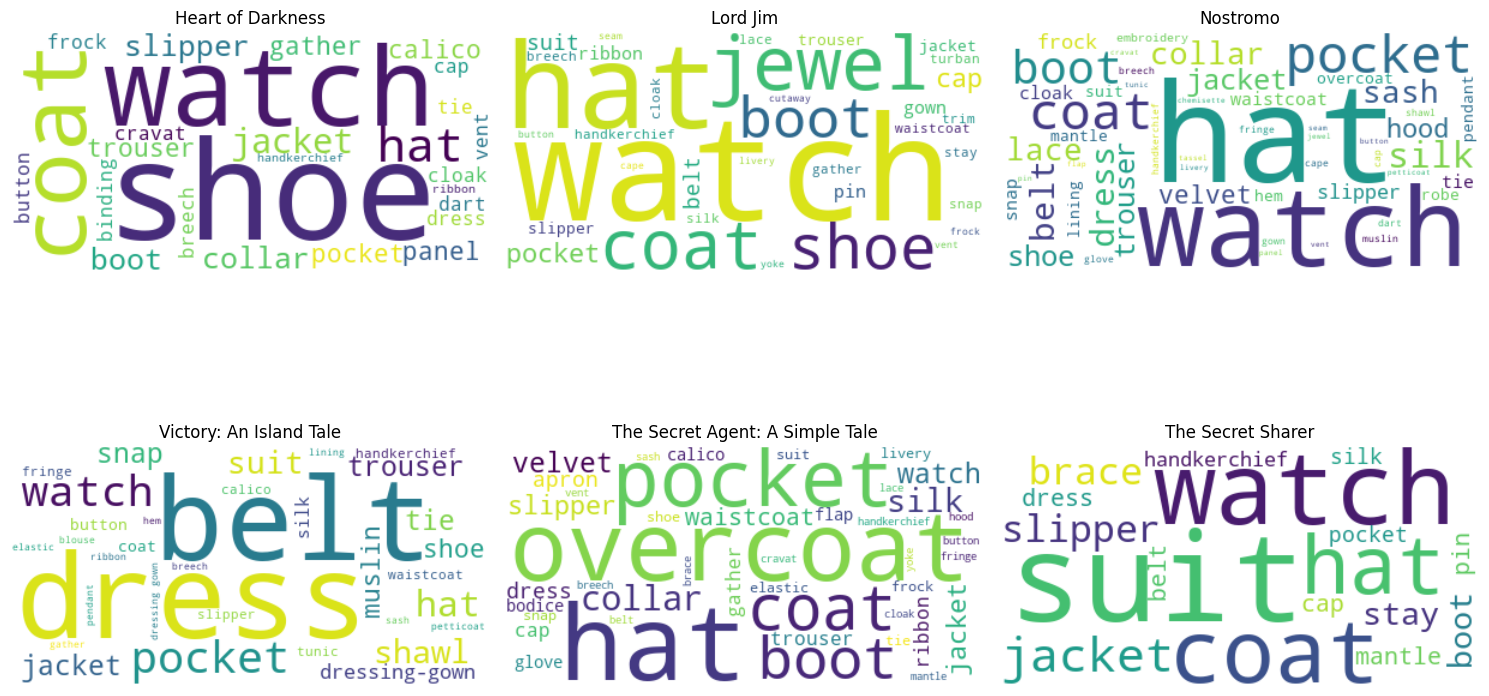

In [53]:
visualise_books_data(conrad)

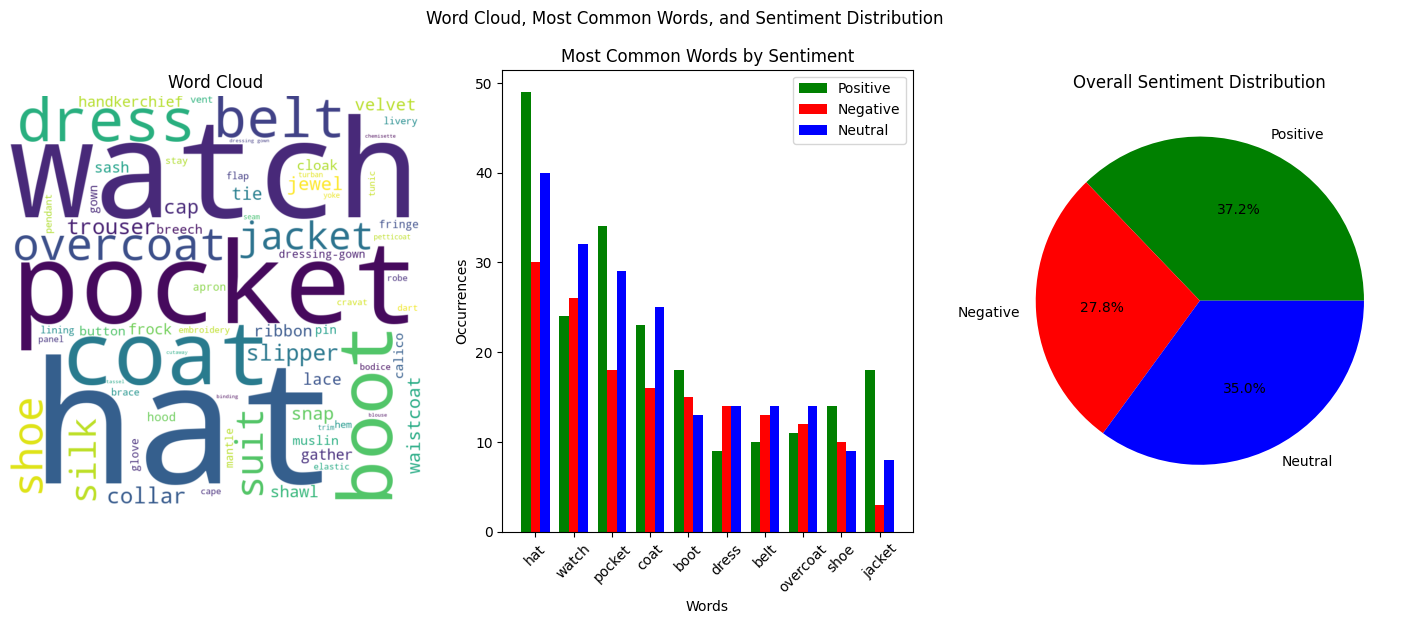

In [54]:
sentiment_and_occurences_visualisation(conrad)

## Making it work for any author

Please input the author name of your choice (their books must be listed on projectgutenberg.org) to get the cothes analysis of their 6 most poopular 

In [55]:
def get_books_by_author(author_name):
    base_url = 'http://gutendex.com/books'
    params = {
        'search': author_name,
        'sort': 'popular',
        'languages': 'en',
        'author_year_end': 9999  # To cover all possible years of publication
    }
    
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        books = data['results'][:6]
        
        result = []
        for book in books:
            title = book['title']
            book_id = book['id']
            text_url= f"https://www.gutenberg.org/cache/epub/{book_id}/pg{book_id}.txt"
            result.append({"title": title, "url": text_url})
        
        return result
    else:
        print(f"Error: {response.status_code}")
        return []

### USAGE

In [56]:
# right now we are 'hardcoding' the author name, but this could be a user input
author_name = "Dickens"
# author_name = input("Enter the author name: ")
books = get_books_by_author(author_name)

In [57]:
print(len(books))
print(books)

6
[{'title': 'A Tale of Two Cities', 'url': 'https://www.gutenberg.org/cache/epub/98/pg98.txt'}, {'title': 'Great Expectations', 'url': 'https://www.gutenberg.org/cache/epub/1400/pg1400.txt'}, {'title': 'A Christmas Carol in Prose; Being a Ghost Story of Christmas', 'url': 'https://www.gutenberg.org/cache/epub/46/pg46.txt'}, {'title': 'Oliver Twist', 'url': 'https://www.gutenberg.org/cache/epub/730/pg730.txt'}, {'title': 'David Copperfield', 'url': 'https://www.gutenberg.org/cache/epub/766/pg766.txt'}, {'title': 'Hard Times', 'url': 'https://www.gutenberg.org/cache/epub/786/pg786.txt'}]


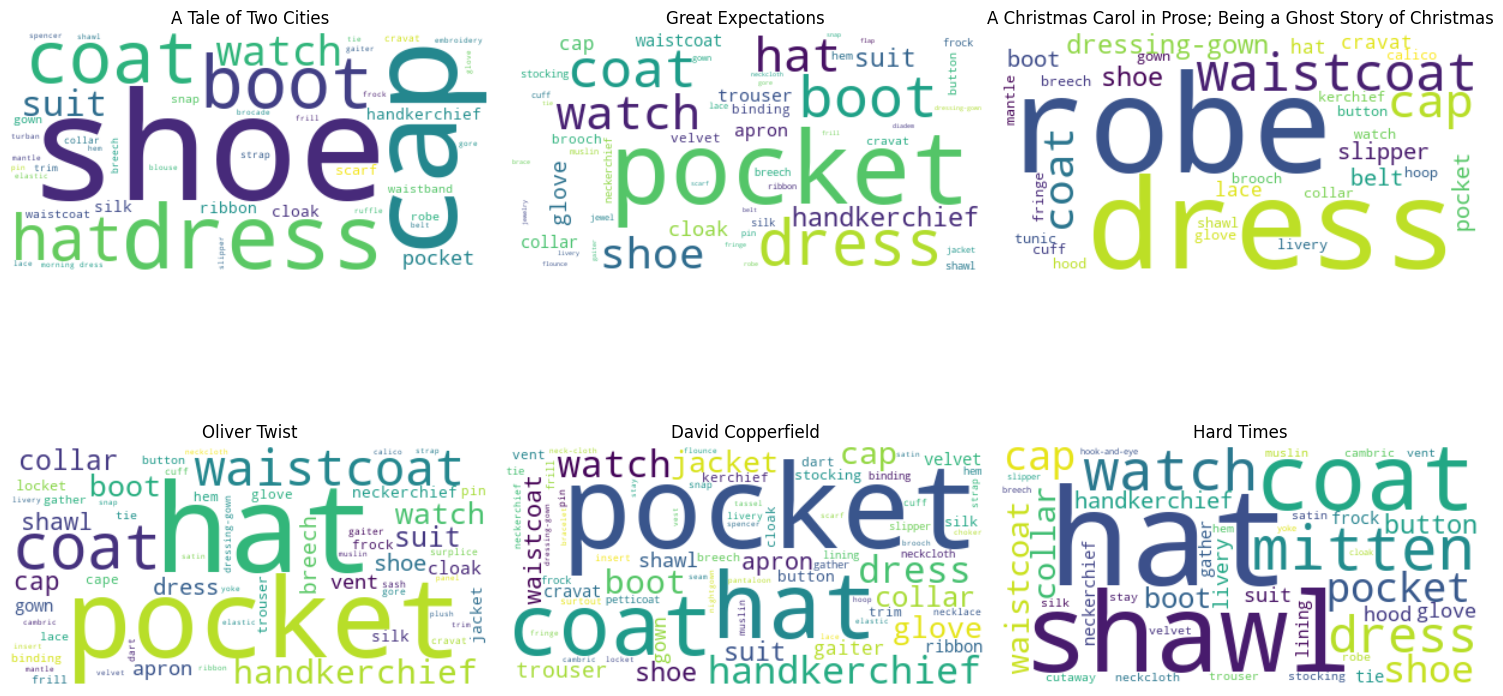

In [58]:
visualise_books_data(books)

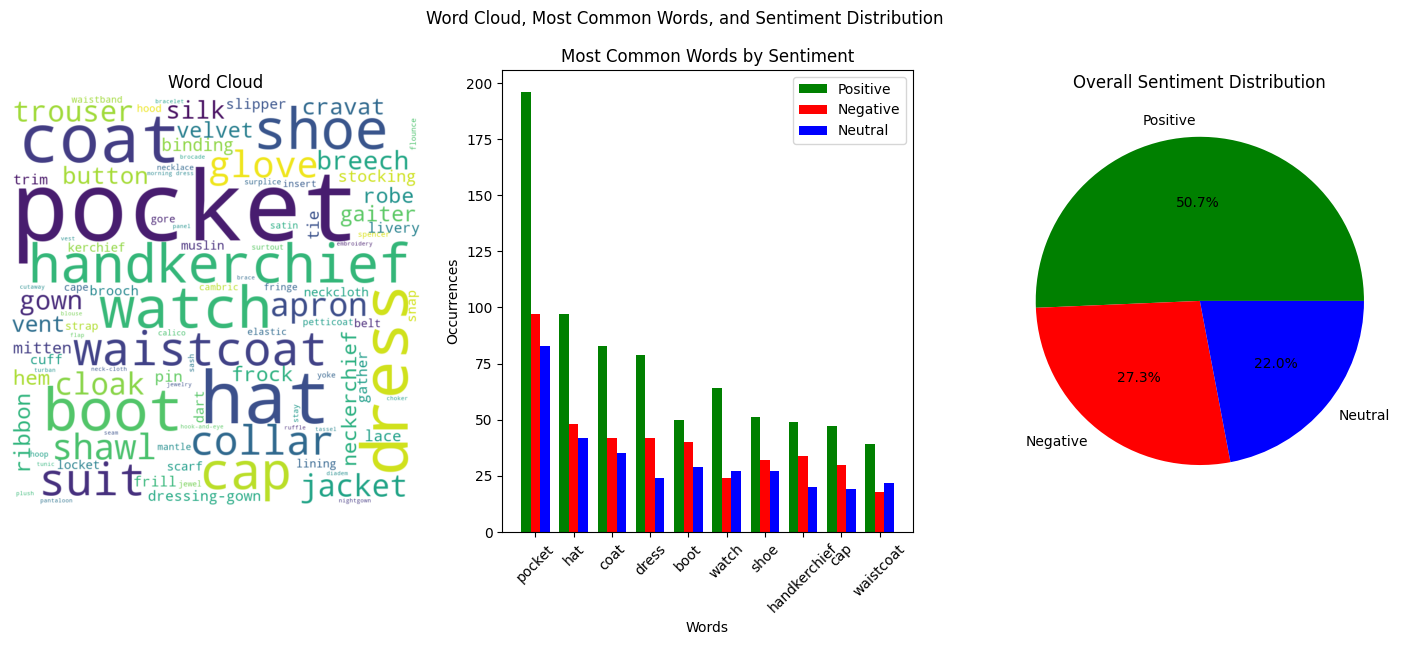

In [59]:
sentiment_and_occurences_visualisation(books)

In [64]:
books = get_books_by_author("Agatha Christie")
print(len(books))

6


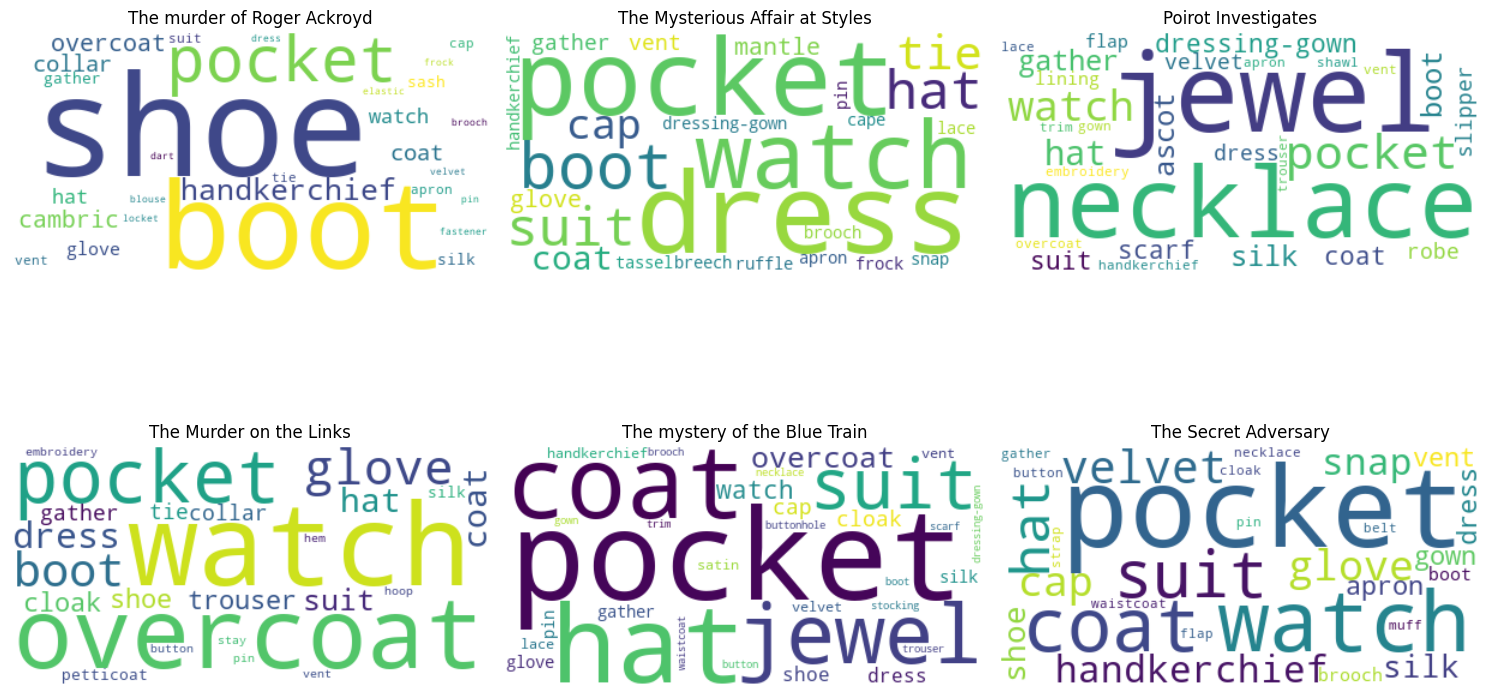

In [65]:
visualise_books_data(books)

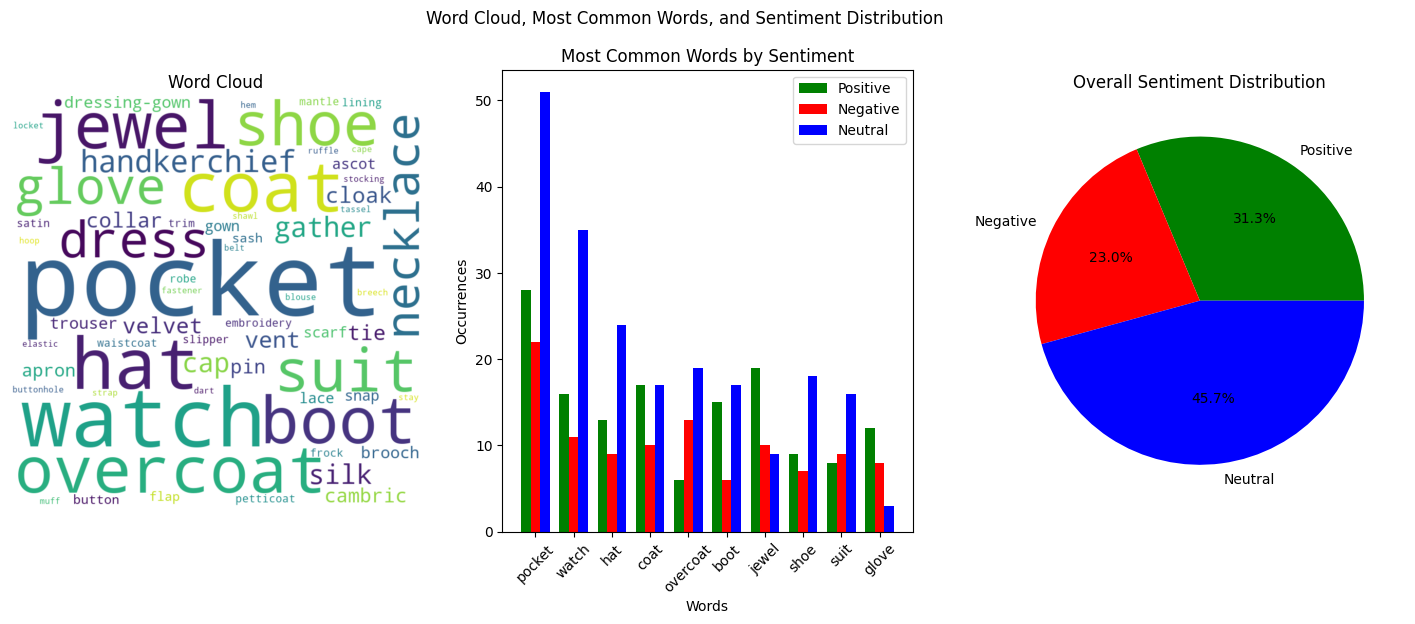

In [66]:
sentiment_and_occurences_visualisation(books)